__Link Two Datasets and Export Results for Future Use__

# DataLinker

## API

### _import DataLinker as dl_

***

__dl.DataLinker__ ( _alg_='PseudoRef', _numLandmark_=10, _probSeq1_=numpy.arange(0.05,0.975,0.05), _probSeq2_=numpy.arange(0.05,0.975,0.05), _dimEmbed_=2, _numEigen_=10, _k_=10, _alpha_=0.5 )

Instantiates a DataLinker class object.

Inputs:

1. _alg_: the data-linking algorithm to use ('PCA' or 'PseudoRef'). General advice: use 'PseudoRef' if the distributions of the two datasets differ, 'PCA' if they are the same.
2. _numLandmark_: the number of pseudo-landmarks to generate. This only applies for 'PseudoRef'. Pseudo-landmarks are selected elements of one dataset that closely match elements of the second dataset, in observables space. If the distributions of the data are not the same, pseudo-landmarks are required to estimate data alignment. Increasing the number of landmarks does not discernably affect computation time, so if an initial dataset match is sub-par one should perhaps try linking again after increasing this quantity.
3. _probSeq1_,_probSeq2_: probability sequences for dataset 1 and 2, respectively. These are used to determine a grid of scales for creating diffusion maps for the two datasets; all scale pairs are examined, with the pair that yields the lowest loss being retained for the final linking.
4. _dimEmbed_: the number of dimensions of the embedding (here, diffusion) space. For now, ignored; _dimEmbed_ = 2.
5. _numEigen_: essentially, the number of dimensions of the computed diffusion space, from which only the top _dimEmbed_ dimensions are retained.
6. _k_: number of nearest neighbors to each data point to use when estimating centering/scaling parameters for the to-be-compared diffusion maps.
7. _alpha_: how to mix estimated landmark loss and Hausdorff loss into a single metric. This only applies for 'PseudoRef'. loss = alpha x landmark loss + ( 1 - alpha ) x Hausdorff loss.

Outputs:

1. An instance of class DataLinker.

***

__dl.link__ ( _dataSet1_ , _dataSet2_ )

Establishes the link between two datasets.

Inputs:

1. _dataSet1_,_dataSet2_: two datasets assumed to have the same number of columns (features).

Outputs:

1. _link1_,_link2_: dictionaries from which one can construct plots or do subsequent matching/prediction.

For 'PseudoRef', the entries in a link dictionary are

-  'diffcoord': the diffusion coordinates of the dataset
-  'eps': the scale parameter for the diffusion map (see _probSeq1_ and _probSeq2_ above)
-  'landmark': the rows of the input data frame that correspond to each landmark.
-  'center','scale','k','Q','eigenvals': transformation quantities used by downstream functions (like predict)

'PCA' has the same entries, except 'landmarks' and 'k'.

***

__dl.predict__ ( _linkDict_ , _distTestTrain_ )

Estimates diffusion coordinates for test data given that dataset's linking dictionary. Used in conjunction with _match()_ to select matching data from the other dataset.

(Example: we have Galacticus SED test data, and for each we want to determine the k nearest SEDs in our SDSS sample. We first have to determine *where* the SEDs are in diffusion space [via _predict()_] and then we can match those coordinates to those of SDSS SEDs [via _match()_].)

Inputs:

1. _linkDict_: a dictionary containing linking information for a dataset, as output by _link()_.
2. _distTestTrain_: a distance matrix between a dataset's test subset and its training subset, computed using, e.g., _euclidean_distances(dataTest,dataTrain)_.

Outputs:

1. _predCoord_: predicted diffusion coordinates

***

__dl.match__ ( _linkDict_ , _dataSet_ , _kMatch_=5 )

Determines the _kMatch_ nearest matches to _dataSet_, using _linkDict_.

(Example: _dataSet_ may be output from _predict()_, e.g., diffusion coordinates for Galacticus test data, while _linkDict_ may be the linking dictionary for SDSS. _match()_ will return the indices of the _kMatch_ nearest matching rows in the SDSS dataset.)

Inputs:

1. _linkDict_: a dictionary containing the linking information for the target dataset, as output by _link()_.
2. _dataSet_: set of diffusion coordinates for the query dataset.
3. _kMatch_: the number of matches in the target dataset to return.

Outputs:

1. _matchingIndices_: the rows of the matching data in the target dataset.
2. _matchingWeights_: a weight estimate for each match, based on the relative distance to that match.


In [12]:
# Example usage of the datalinker module (Peter Freeman, based on R code by Jaehyeok Shin)
#
# Here we attempt to link Galacticus SEDs from LSST proto-DC2 (v3) to degraded SDSS SEDs from Beck et al. (2016),
# as part of a code pipeline that is meant to add sampled emission lines to the continuum-only Galacticus SEDs.
#
import pandas
import numpy as np
import time
import pickle

import DataLinker as dl

start = time.time()

# Each of the degraded datasets has 12 columns. Note that the code 
# in the datalinker module will not work if the number of columns differs,
# i.e., you are expected to degrade your spectra to the same wavelength
# grid prior to using the datamatching module!

# While it would be preferable to use all ~10,000 SDSS galaxies in training
# the linker, it is too computationally intensive to do so (estimated CPU hours,
# high memory usage).
# 1000 galaxies + 700 Galacticus training galaxies => ~90 CPU seconds on my iMac
dataSDSS    = np.loadtxt("./SDSS_sample.txt",skiprows=1)
rSDSS,cSDSS = np.shape(dataSDSS)

np.random.seed(103)
dfGal        = pandas.read_feather("./Galacticus_sample.feather")
dataGal      = np.ascontiguousarray(dfGal.values)
dataGalTrain = dataGal[0:700,:]
dataGalTest  = dataGal[700:1000,:]
rGal,cGal    = np.shape(dataGalTrain)

if cSDSS == cGal:
    dlObj            = dl.DataLinker(numLandmark=25)
    linkSDSS,linkGal = dlObj.link(dataSDSS,dataGalTrain)
    # We dump information on the linking of Galacticus and SDSS to a pickle file; in
    # another notebook, we read this in, re-open the linker, and use this information
    # in conjunction with datalinker.predict() to link a test-set Galacticus galaxy to
    # the nearest training-set SDSS galaxies. (This then allows us to predict the CDE
    # for emission lines for that galaxy, given the existing link between SDSS continua
    # and their lines.)
    # with open('link.pkl','wb') as f:
    #     pickle.dump([linkSDSS,linkGal,dataSDSS,dataGalTrain],f)
else:
    print('Data defined incorrectly: column number mismatch.')

print('Time: ',time.time()-start)

Time:  87.16629004478455


__Plot the linked datasets in diffusion space__

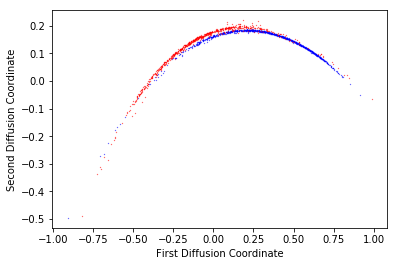

In [13]:
import matplotlib.pyplot as plt

# Blue points: SDSS data in 2D diffusion space
# Red points:  Galacticus training data
X = linkSDSS['diffcoord']
Y = linkGal['diffcoord']
plt.plot(X[:,0],X[:,1],'b.',Y[:,0],Y[:,1],'r.',markersize=0.5)
plt.xlabel('First Diffusion Coordinate')
plt.ylabel('Second Diffusion Coordinate')
plt.show()

__Plot the original data__

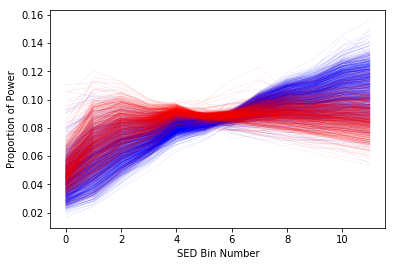

In [14]:
import matplotlib.pyplot as plt

for ii in range(rSDSS):
    plt.plot(range(cSDSS),dataSDSS[ii,:],'b',linewidth=0.1,alpha=0.5)
for ii in range(rGal):
    plt.plot(range(cGal),dataGal[ii,:],'r',linewidth=0.1,alpha=0.5)
plt.xlabel('SED Bin Number')
plt.ylabel('Proportion of Power')
plt.show()

__Plot original data amplitude in chosen bin versus first diffusion coordinates__

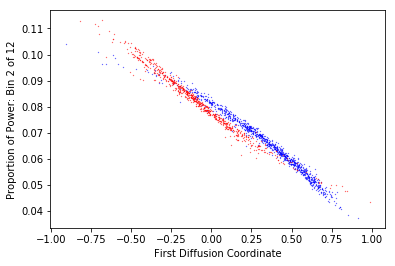

In [15]:
import matplotlib.pyplot as plt

bin = 2

plt.plot(X[:,0],dataSDSS[:,bin],'b.',Y[:,0],dataGalTrain[:,bin],'r.',markersize=0.5)
plt.xlabel('First Diffusion Coordinate')
plt.ylabel('Proportion of Power: Bin '+str(bin)+' of 12')
plt.show()

__Plot H_alpha equivalent width versus first diffusion coordinate__

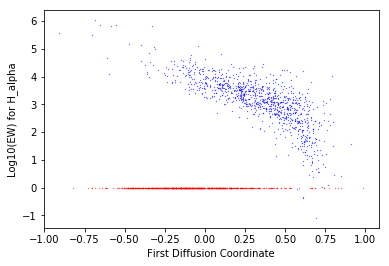

In [16]:
import matplotlib.pyplot as plt

dataSDSSEmission = np.loadtxt("SDSS_emission_sample.txt",skiprows=1)
r,c = np.shape(dataGalTrain)
plt.plot(X[:,0],dataSDSSEmission[:,0],'b.',Y[:,0],np.zeros(r),'r.',markersize=0.5)
plt.xlabel('First Diffusion Coordinate')
plt.ylabel('Log10(EW) for H_alpha')
plt.show()

__Convert test data in query space (Galacticus) to test data in reference space (SDSS)__

In [17]:
from sklearn.metrics.pairwise import euclidean_distances

#
# The exact details of data matching are still up in the air. Here, we find the nearest
# kMatch neighbors of each Galacticus spectrum, with approximate matching weights (based
# on distance), and compute a weighted combination.
#
kMatch          = 10
predOutput      = dlObj.predict(linkGal,euclidean_distances(dataGalTest,dataGalTrain))
indSDSS,weiSDSS = dlObj.match(linkSDSS,predOutput,kMatch=kMatch)

r,c             = np.shape(dataGalTest)
sedTest         = np.zeros((r,c))

for ii in range(r):
    for jj in range(kMatch):
        sedTest[ii,:] = sedTest[ii,:]+weiSDSS[ii,jj]*dataSDSS[indSDSS[ii,jj],:]/np.sum(weiSDSS[ii,:])
        
# ...sedTest may then be passed to a predictor for emission-line strength...